# Image Annotator for Labelling Images Into User-Defined Categories
Adapted from : https://blogs.sas.com/content/subconsciousmusings/2021/11/23/introducing-jupicl-fast-image-labelling-entirely-within-a-jupyter-notebook/

This code displays each image in dataset and allow user to specify weather conditions he can observe (cloudy or not).

Input : PolarizedDatabase folder with cropped images grouped in numpy files, you can download all or only some of the "YYYY-MM-DD_raw.npy" file days to accelerate processing on your computer.

Output : Files with same timestamps than input file in a column and annotations in another column.


## Import packages and define essential helper functions

In [2]:
#import cv2
from IPython.display import display, clear_output
from PIL import Image
import os

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import time


In [3]:
in_path="/scratch/lpoughon/PolarizedDatabase/"
calib_path="/scratch/lpoughon/PolarizedDatabase/calib/"
out_path="/scratch/lpoughon/PolarizedDatabase/"
limit_Zenith_Angle=np.pi*0.5 #Limit Zenith Angle to crop circularly data inside of camera field-of-view.

dirs = os.listdir( in_path ) # Listing Files
dirs_files=[]
for file in dirs:
    if file[-7:]=='raw.npy': # Keeping only ones with ".npy" files. 
        dirs_files.append(file)
dirs_files.sort() #We sort the files in alphabetical order. 
# Since the format is YYYY-MM-DDTHH-mm-ss.npy, the files are sorted in chronological order.

In [4]:
def rebin(arr, new_shape): #https://scipython.com/blog/binning-a-2d-array-in-numpy/
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [5]:
def mkdict_from_user():
    userdict = {}
    while True:
        res = input("Enter 'class_labels:keyboard_shortcut', such as 'bag:b', or 'q' to quit -->  ")
        if res == 'q':
            break
        else:
            key, val = res.split(':')
            userdict[key] = val
    
    return userdict

In [6]:
def get_userinput(user_labels):
    
    notes = 'default'
    
    valid_labels = tuple(user_labels.values())
    
    while True:
        KBN = Keyborad_Shortcut_For_Notes = '7'
        
        userinput = input(f"Valid Shortcuts: {valid_labels} <Append'{KBN}' for Notes> ... ")
        
        L = len(userinput)
        if L not in [1,2]:
            print('Invalid input, try again...')
            continue
        
        if userinput[0] not in valid_labels:
            print(f'Invalid input, valid labels are {valid_labels} try again...')
            continue
            
        if L==2:
            if userinput[1] != KBN:
                print(f"Invalid, second letter if present must be the keyboard shortcut for notes: '{KBN}' ")
            else:
                usernote  = input("Notes: ")
                if len(usernote)>0:
                    notes = usernote
                break
        
        else:
            break
        
    return userinput[0], notes
            

## Define the main driver function for labelling

In [7]:
def goLabel_acq(user_labels, images_pola, liste_sortie_annotee):
    #src_imgdir = f"./images/"

    timestamps=images_pola[:,2]
    # Convert timestamps to datetime objects
    datetime_objects = [datetime.strptime(timestamp, '%Y-%m-%dT%H-%M-%S') for timestamp in timestamps]

    # Round the minutes to the nearest 10 minutes
    rounded_datetimes = [dt.replace(minute=(dt.minute // 10) * 10, second=0) for dt in datetime_objects]

    # Group the timestamps into a dictionary based on rounded timestamps
    result_dict = defaultdict(list)
    result_dict_i = defaultdict(list)

    for i, rounded_dt in enumerate(rounded_datetimes):
        result_dict_i[rounded_dt].append(i)    
        result_dict[rounded_dt].append(timestamps[i])

    # Convert the defaultdict to a regular dictionary for a cleaner output (optional)
    result_dict = dict(result_dict)

    ## Print the result
    #for key, value in result_dict_i.items():
    #    print(f"{key}: {value}")
    
    
    def plot_mosaic(images, rows, cols): # Function to display images in a mosaic plot
        subsampl=4 #subsampling
        fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        fig.suptitle(str(timestamp[0])+" ")
        for i, ax in enumerate(axs.flat):
            if i < len(images):
                img = images[i]
                a=rebin(img,(img.shape[0]//2,img.shape[1]//2))
                imgRGB = (np.stack([a[0::2,0::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
                #imgRGB = (np.stack([img[0::2,1::2],0.5*(img[0::2,1::2]+img[1::2,0::2]),img[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
                ax.imshow(imgRGB[::subsampl,::subsampl])  # Assuming images are grayscale

                #ax.imshow(img[::subsampl,::subsampl], cmap='gray')  # Assuming images are grayscale
                ax.set_title("img_type "+str(image_type[i])+" \n expo : "+str(exposure[i])+" µs")


                ax.axis('off')
            else:
                ax.remove()

        return fig
    

    
    sess_count = 0
    
    for my_datetime in (list(result_dict_i.keys())):
        
        # Extract image data, exposure, and timestamp from the array
        indices_to_highlight=result_dict_i[my_datetime]
        data = images_pola[indices_to_highlight,:]
    
    
        images = data[:, 0]
        exposure = data[:, 1]
        timestamp = data[:, 2]
        image_type=data[:,3]

        N=data.shape[0]

        sess_count += 1

        # Specify the number of rows and columns in the mosaic
        cols = 4
        rows = N//cols+1


        # Display the mosaic plot
        mafig=plot_mosaic(images, rows, cols)
        display(plt.gcf()) 
        #display(Image.fromarray(img))
        print(f'Now Showing {timestamp[0]}'+" ("+str(sess_count)+"/"+str(len(list(result_dict_i.keys())))+")")
        
        label, notes = get_userinput(user_labels)
        liste_sortie_annotee[indices_to_highlight,1]=label#'c'
        print("Choisi : ",label)
        #if notes != 'default':

        
        clear_output()
        

        plt.close()
    

    print(f"You Labelled {sess_count} images in this round. Hooray!")
    return liste_sortie_annotee#Notes

## Set up labels and keyboard shortcuts

#### For example :

dark_sky:n (night)

clear_sky:c

mist:m

few_clouds:f (11-25%)

scattered_clouds:s (25-50%) 

broken_clouds:b (51-84%)

overcast_clouds:o (85-100%)

In [9]:
user_labels={'dark_sky': 'n',
 'clear_sky': 'c',
 'mist': 'm',
 'few_clouds': 'f',
 'scattered_clouds': 's',
 'broken_clouds': 'b',
 'overcast_clouds': 'o'}

In [ ]:
#user_labels = mkdict_from_user() #uncomment to change user labels

## Labelling days

### Annotated so far :

In [55]:
dirs_ann = os.listdir( out_path ) # Listing Files
dirs_ann_files=[]
for file in dirs_ann:
    if file[-19:]=='raw_annotations.npy': # Keeping only ones with ".npy" files. 
        dirs_ann_files.append(file)
dirs_ann_files.sort() #We sort the files in alphabetical order. 
#print(dirs_ann_files)

In [56]:
liste_dates=[]
for i in range(len(dirs_files)):
    rec=dirs_files[i].split('_raw.npy')[0]+'_raw_annotations.npy'
    liste_dates.append(dirs_files[i].split('_raw.npy')[0])
    if rec in dirs_ann_files:
        print(i," ",dirs_files[i]," ",rec)
    else:
        print(i," ",dirs_files[i])

0   2022-07-29_raw.npy   2022-07-29_raw_annotations.npy
1   2022-07-30_raw.npy   2022-07-30_raw_annotations.npy
2   2022-07-31_raw.npy   2022-07-31_raw_annotations.npy
3   2022-08-01_raw.npy   2022-08-01_raw_annotations.npy
4   2022-08-02_raw.npy   2022-08-02_raw_annotations.npy
5   2022-08-03_raw.npy   2022-08-03_raw_annotations.npy
6   2022-08-04_raw.npy   2022-08-04_raw_annotations.npy
7   2022-08-05_raw.npy   2022-08-05_raw_annotations.npy
8   2022-08-06_raw.npy   2022-08-06_raw_annotations.npy
9   2022-08-07_raw.npy   2022-08-07_raw_annotations.npy
10   2022-08-08_raw.npy   2022-08-08_raw_annotations.npy
11   2022-08-09_raw.npy   2022-08-09_raw_annotations.npy
12   2022-08-10_raw.npy   2022-08-10_raw_annotations.npy
13   2022-08-11_raw.npy   2022-08-11_raw_annotations.npy
14   2022-08-12_raw.npy   2022-08-12_raw_annotations.npy
15   2022-08-13_raw.npy   2022-08-13_raw_annotations.npy
16   2022-08-14_raw.npy   2022-08-14_raw_annotations.npy
17   2022-08-15_raw.npy   2022-08-15_raw_

### Choose file to annotate by changing the number you want

In [51]:
day_wanted=12# Change that to choose what day to annotate
print("Day number : ",day_wanted)
print("File used :",in_path+dirs_files[day_wanted])
images_pola=np.load(in_path+dirs_files[day_wanted],allow_pickle=True)
save_path=out_path+dirs_files[day_wanted].split(".npy")[0]+"_annotations.npy"
print("Will save results in :"+save_path)
#images=images_pola[:,0]
# the list that will contain timestamps and corresponding annotations
liste_sortie_annotee=np.array(images_pola[:,2])
liste_sortie_annotee=np.c_[liste_sortie_annotee,np.zeros(liste_sortie_annotee.shape[0])]

Day number :  12
File used : /scratch/lpoughon/PolarizedDatabase/2022-08-10_raw.npy
Will save results in :/scratch/lpoughon/PolarizedDatabase/2022-08-10_raw_annotations.npy


### Let's annotate !

In [52]:
tic=time.time()
labels=goLabel_acq(user_labels, images_pola, liste_sortie_annotee)
print("Labelling took ",int(time.time()-tic)," s")
np.save(save_path,labels)

You Labelled 94 images in this round. Hooray!
Labelling took  228  s


dark_sky:n (night)

clear_sky:c

few_clouds:f (11-25%)

scattered_clouds:s (25-50%) 

broken_clouds:b (51-84%)

overcast_clouds:o (85-100%)

In [13]:
save_path

'/scratch/lpoughon/PolarizedDatabase/2022-08-05_raw_annotations.npy'

In [1]:
user_labels

NameError: name 'user_labels' is not defined

In [16]:
liste_dates

['2022-07-29',
 '2022-07-30',
 '2022-07-31',
 '2022-08-01',
 '2022-08-02',
 '2022-08-03',
 '2022-08-04',
 '2022-08-05',
 '2022-08-06',
 '2022-08-07',
 '2022-08-08',
 '2022-08-09',
 '2022-08-10',
 '2022-08-11',
 '2022-08-12',
 '2022-08-13',
 '2022-08-14',
 '2022-08-15',
 '2022-08-16',
 '2022-08-17',
 '2022-08-18',
 '2022-08-19',
 '2022-08-20',
 '2022-08-21',
 '2022-08-22',
 '2022-08-23',
 '2022-08-24',
 '2022-08-25',
 '2022-08-26',
 '2022-08-27',
 '2022-08-28',
 '2022-08-29']

In [48]:
dirs_ann = os.listdir( out_path ) # Listing Files
dirs_ann_files=[]
for file in dirs_ann:
    if file[-19:]=='raw_annotations.npy': # Keeping only ones with ".npy" files. 
        dirs_ann_files.append(file)
dirs_ann_files.sort() #We sort the files in alphabetical order. 
#print(dirs_ann_files)

In [49]:

from datetime import datetime, timedelta


def mosaique_meteos(dirs_ann_files,user_labels):
    start_hour=6
    end_hour=22
    
    liste_dates=[]
    for filen in dirs_files:
        liste_dates.append(filen.split("_raw")[0])
    print(liste_dates)
    a=np.full((97,len(liste_dates)), 'missing')
    
    for file in dirs_ann_files:
        print(file)
        date=file.split("_raw")[0]
        id_date=np.where(np.array(liste_dates)==date)[0][0]
        input_array=np.load(out_path+file,allow_pickle=True)
        #input_array=np.array([[None,None]])
    

        # Function to convert timestamp to datetime object
        def parse_timestamp(timestamp):
            return datetime.strptime(timestamp, '%Y-%m-%dT%H-%M-%S')


        current_date = parse_timestamp(input_array[0, 0]).replace(hour=0, minute=0, second=0, microsecond=0)
        start_time = current_date + timedelta(hours=6)
        end_time = current_date + timedelta(hours=22)
        time_step = timedelta(minutes=10)
        current_time = start_time
        result_array = []

        while current_time <= end_time:
            timestamp_str = current_time.strftime('%Y-%m-%dT%H-%M-%S')
            # Find the nearest timestamp in the input array
            nearest_timestamp = min(input_array[:, 0], key=lambda x: abs(parse_timestamp(x) - current_time))
            if parse_timestamp(nearest_timestamp) >= current_time and parse_timestamp(nearest_timestamp) <= current_time + time_step:
                color = input_array[input_array[:, 0] == nearest_timestamp, 1][0]
                result_array.append([timestamp_str, color])
            else:
                result_array.append([timestamp_str, 'missing'])
            current_time += time_step


        result_array=np.array(result_array)

        a[:,id_date]=(np.array(result_array)[:,1])
        
    return a

['2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29']
2022-07-29_raw_annotations.npy
2022-07-30_raw_annotations.npy
2022-07-31_raw_annotations.npy
2022-08-01_raw_annotations.npy
2022-08-02_raw_annotations.npy
2022-08-03_raw_annotations.npy
2022-08-04_raw_annotations.npy
2022-08-05_raw_annotations.npy
2022-08-06_raw_annotations.npy
2022-08-07_raw_annotations.npy
2022-08-08_raw_annotations.npy
2022-08-09_raw_annotations.npy
2022-08-10_raw_annotations.npy
2022-08-11_raw_annotations.npy
2022-08-12_raw_annotations.npy
2022-08-13_raw_annotations.npy
2022-08-14_raw_annotations.npy
2022-08-15_raw_annotatio

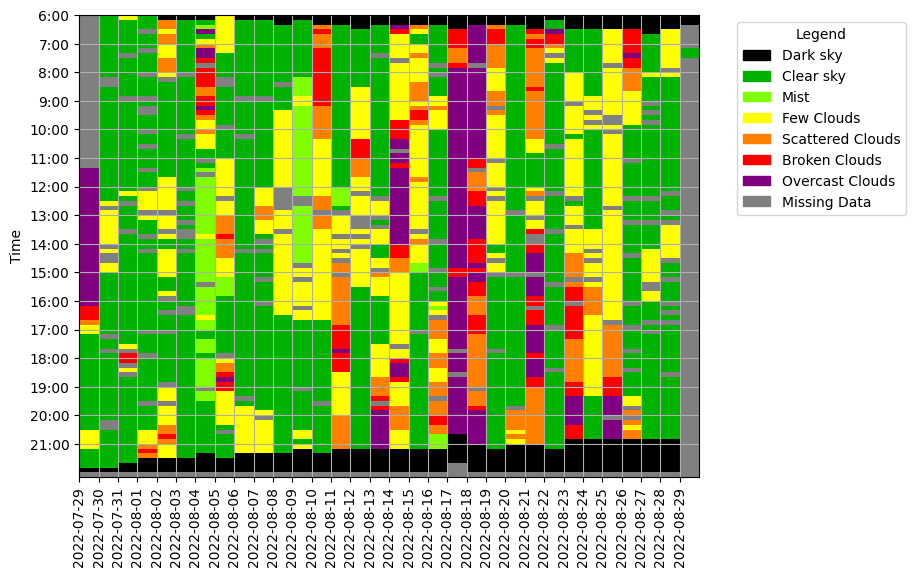

In [54]:
from matplotlib.patches import Patch
from matplotlib.ticker import FixedLocator, FuncFormatter, MultipleLocator

# Define the color table
color_table = mosaique_meteos(dirs_ann_files,user_labels)

# Define a custom mapping of colors to RGB values
color_mapping = {
    'n': [0, 0, 0],
    'c': [0, 0.7, 0],
    'm': [0.5, 1, 0],
    'f': [1, 1, 0],
    's': [1, 0.5, 0],
    'b': [1, 0, 0],
    'o': [0.5, 0, 0.5],
    'missing': [0.5, 0.5, 0.5]
}

# Convert color names to RGB values using the custom mapping
rgb_colors = np.array([[color_mapping[color] for color in row] for row in color_table])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create a pcolormesh plot using custom colors
cax = ax.pcolormesh(np.arange(rgb_colors.shape[1] + 1),
                    np.arange(rgb_colors.shape[0] + 1),
                    rgb_colors)

# Turn off axis labels
#ax.axis('off')

# Create a legend with custom color patches
legend_patches = [
    Patch(color=color_mapping['n'], label='Dark sky'),
    Patch(color=color_mapping['c'], label='Clear sky'),
    Patch(color=color_mapping['m'], label='Mist'),
    Patch(color=color_mapping['f'], label='Few Clouds'),
    Patch(color=color_mapping['s'], label='Scattered Clouds'),
    Patch(color=color_mapping['b'], label='Broken Clouds'),
    Patch(color=color_mapping['o'], label='Overcast Clouds'),
    Patch(color=color_mapping['missing'], label='Missing Data')
]

# Add the legend to the plot
ax.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

#hours = np.arange(6, 22, 10/60)
#hours = np.arange(6, 22, 2)  # Change the step to adjust the number of ticks
#ax.set_yticks(np.arange(len(hours)) + 0.5)
#ax.set_yticklabels([f'{int(h)}:{int((h % 1) * 60):02d}' for h in hours])
#ax.set_yticklabels([])




# Add y-axis ticks and labels for time from 6:00 to 22:00 with 10-minute intervals
#ax.set_yticks(np.arange(0.5, 16.5, 1))  # 16 rows from 6:00 to 22:00
#ax.set_yticklabels([f'{hour:02d}:{minute:02d}' for hour in range(6, 23) for minute in range(0, 60, 10)])

ytick_locations = np.arange(0, (22-6)*6, 6)
ytick_labels = [f'{int(hour/6+6)}:00' for hour in ytick_locations]
#print(ytick_locations)
#print(ytick_labels)
plt.yticks(ytick_locations, ytick_labels)
plt.ylabel('Time')

#ax.set_yticklabels([f'{int(h)}:00' for h in hours])
ax.invert_yaxis()

ax.set_xticks(np.arange(len(liste_dates)) + 0.5*0)
ax.set_xticklabels(liste_dates,rotation='vertical')

# Define custom minor tick locations for the x-axis
#yticks_minor = ytick_locations# np.arange(0.5, 10.5, 1)

# Define custom minor tick locations for the y-axis
#xticks_minor = np.arange(0, 11, 1)


ax.grid()

# Define custom minor tick locations for the y-axis
xticks_minor = np.arange(len(liste_dates)) + 0.5

# Show the plot
plt.show()
